## Load packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.morphology as morph
from skimage import filters
from scipy import ndimage
%matplotlib inline

# Exercise 1: The Histogram

Open the image "comp_noise.png" and show it

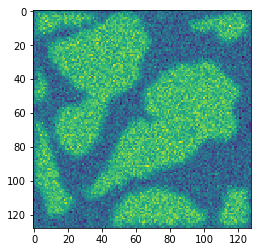

In [2]:
img=plt.imread('comp_noise.png')

plt.imshow(img)

The histogram is created by [https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.histogram.html](numpy.histogram)

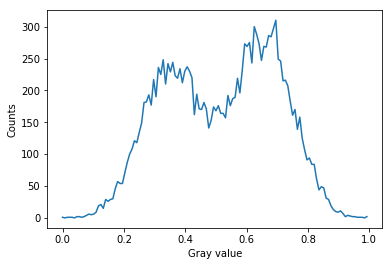

In [3]:
hist,axis = np.histogram(img,bins=128)
plt.plot(axis[0:-1],hist)
plt.xlabel('Gray value')
plt.ylabel('Counts')

You can apply a threshold by computing the expression $bimg=>th$, where th is the threshold.

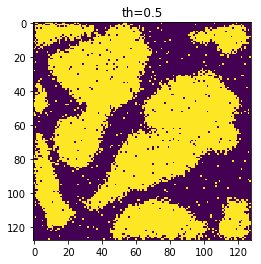

In [4]:
bimg=0.5<img
plt.imshow(bimg)
plt.title('th=0.5')

# Now, create two subplots with images where the thresholds are placed on
the first and second histogram peaks. Add the previous image segmented between the peaks. 

Q1.1: What is your conclusion about the thresholds at the three positions in the histogram?

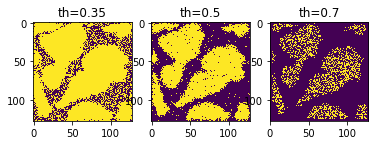

In [5]:
bimg_lo=0.35<img
plt.subplot(1,3,1)
plt.imshow(bimg_lo)
plt.title('th=0.35')

bimg_mid=0.50<img
plt.subplot(1,3,2)
plt.imshow(bimg_mid)
plt.title('th=0.5')

bimg_hi=0.70<img
plt.subplot(1,3,3)
plt.imshow(bimg_hi)
plt.title('th=0.7')

### Conclusion: 
- t=0.35: The grains are solid without any misclassified pixels, but the pore space has plenty misclassified pixels.
- t=0.5 : There is a balance between the amount of misclassified pixels in grains and pores
- t=0.7 : The pore space is clean, but the grains are badly represented.

# Exercise 2: Explore thresholding methods
Use the same image as in the previous exercise. SciKit Image provides many thresholding methods http://scikit-image.org/docs/dev/auto_examples/xx_applications/plot_thresholding.html.

One is the Otsu threshold. To segment an image you perform the following steps.

The threshold according to 0.509765625


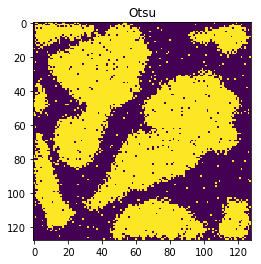

In [6]:
otsu = filters.threshold_otsu(img)
print('The threshold according to',otsu)
plt.imshow(otsu<img)
plt.title('Otsu')

Using the try_all_threshold function you can evaluate the performance of different available thresholding methods. See example in the documentation. 

Q2.1: Is there any difference? 

Q2.2: Please explain why? Hint, try the function on a more complex image.

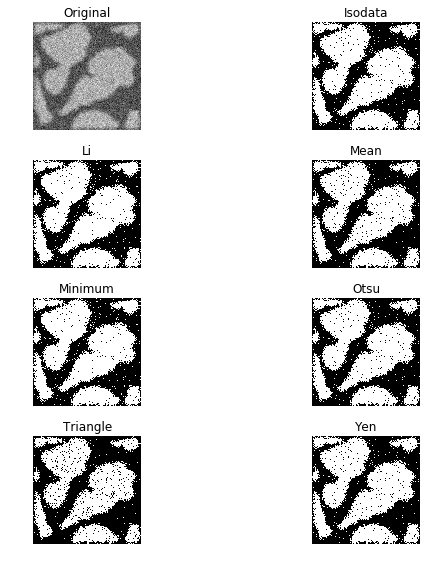

In [9]:
from skimage.filters import try_all_threshold

fig,ax = try_all_threshold(img,figsize=(10,8), verbose=False)
plt.show()

### Answers:
Q2.1: There is only a minimal difference. The amount of misclassified pixels are about the same in all. Some 
        methods put more focus on the upper mode (Li) while others put more focus on the lower mode.
        
Q2.2: The example image has a simple histogram with two distinct modes. The different thresholding 
        methods are designed for specific use cases of natural images where they will outperform the other methods. 

# Exercise 3: Threshold based on likelihood ratio

Segment it using the
following hypotheses:
\begin{eqnarray}
H_0 &:& \mathcal{N}(0,1)\nonumber\\
H_1 &:& \mathcal{N}(0,2.5)\nonumber
\end{eqnarray}

Compute the log-likelihood ratio from
$\Lambda(R)=\frac{p_{r|H_1}(R|H_1)}{p_{r|H_0}(R|H_0)}=\gamma$
with
\begin{eqnarray}
p_{r|H_0}(R|H_0)&=& \prod_{i=1}^{N}\frac{1}{\sqrt{2\,\pi}\sigma_0}\exp{\frac{{R_i}^2}{2\,{\sigma_0}^2}}\nonumber\\
p_{r|H_1}(R|H_1)&=&\prod_{i=1}^{N}\frac{1}{\sqrt{2\,\pi}\sigma_1}\exp{\frac{{R_i}^2}{2\,{\sigma_1}^2}}
\nonumber
\end{eqnarray}

The evaluation of the likelihood ratio is found in van Trees p. 29 (included PDF). From this evaluation it is given that
1. The local sum of squares ($l(R)=\sum_{i=1}^{N} R_i^2 $) is our sufficient statistic
2. The threshold is $l(R) \lessgtr \frac{2\sigma_0^2 \sigma_1^2}{\sigma_1^2 - \sigma_0^2} \left(N \ln\frac{\sigma_0}{\sigma_1}-\ln \eta\right)=\gamma$


$h_{N\times N}$ is box filter with all weights =1 and $f_{median}$ is median filtered with $N\times N$.

First, we need some data. 

- Use the Bi-level image of the grains and set the pore space distribution to $\mathcal{N}(0,2.5)$ and the grain distribution to $\mathcal{N}(0,1)$
- Display the image
- Compute and plot the histogram

Q3.1: What is you conclusion about the histogram?

Q3.2: Apply an Otsu threshold to the image. What happens?

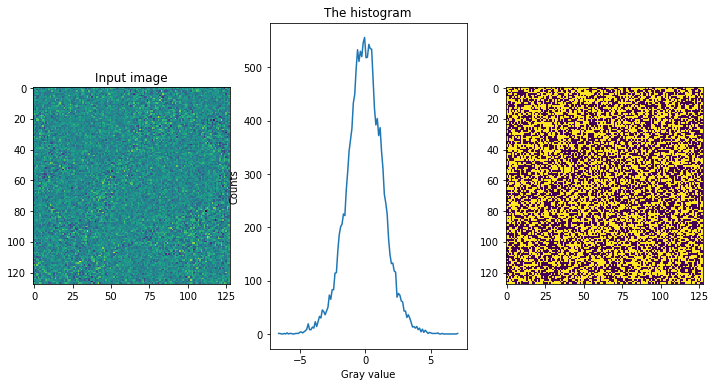

In [39]:
# Solution
s0=1
s1=2.5
simg=img*(np.random.normal(0,s0,img.shape))+(1-img)*(np.random.normal(0,s1,img.shape))
plt.figure(figsize=[12,6])
plt.subplot(1,3,1)
plt.imshow(simg)
plt.title("Input image")
plt.subplot(1,3,2)
hist,axis = np.histogram(simg,bins=128)
plt.plot(axis[0:-1],hist)
plt.title('The histogram')
plt.xlabel('Gray value')
plt.ylabel('Counts')


plt.subplot(1,3,3)
otsu = filters.threshold_otsu(simg)
plt.imshow(otsu<simg)


### Answer:
Q3.1 : The histogram only has a single mode. In fact the two distributions are centered around the same average value.
    Therefore, it is not possible to use any of the previously tested thresholding methods.
    
Q3.2 : Otsu completely fails to segment images of this type

Verify if it makes sense to use the sufficient statistic. 
- Filter the image intensity values squared, try N=5 and N=7
- Apply a uniform filter (kernel size NxN with all elements = 1) 

Q3.3: What happens with increasing N?

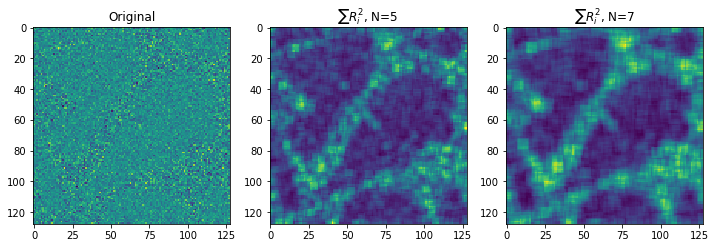

In [25]:
plt.figure(figsize=[12,7])
plt.subplot(1,3,1)
plt.imshow(simg)
plt.title('Original')
plt.subplot(1,3,2)
plt.imshow(ndimage.uniform_filter(simg**2,5))
plt.title("$\sum R_i^2$, N=5")

plt.subplot(1,3,3)
plt.imshow(ndimage.uniform_filter(simg**2,7))
plt.title("$\sum R_i^2$, N=7")



### Answer:
Q3.2: The structures become clearer, but the cost is that small details are lost.

Now define a function for the likelihood ratio...

In [29]:
# Solution
def LikelihoodRatio(img,s0,s1,N,eta) :
    img2 = ndimage.uniform_filter(img**2,N)*N**2
    gamma = ((2 * s0**2 * s1**2)/(s1**2-s0**2)*(np.log(eta)-N*N*np.log(s0/s1)))
    res= img2 < gamma
    return res

Test your function with different values of N=5,7 and $\eta$=0.001,0.005,0.1

Q3.4 What is the effect of N

Q3.5 What is the effect of $\eta$


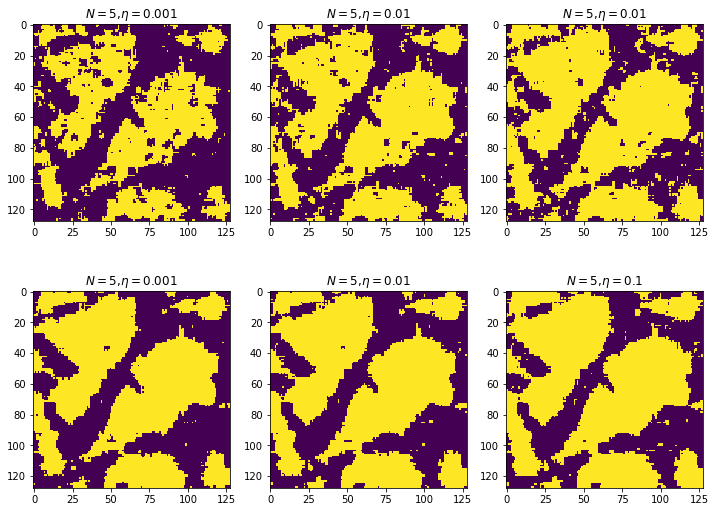

In [37]:
# Soultion
plt.figure(figsize=(12,9))
plt.subplot(2,3,1)
plt.imshow(LikelihoodRatio(simg,s0,s1,5,0.001))
plt.title("$N=5$,$\eta=0.001$")

plt.subplot(2,3,2)
plt.imshow(LikelihoodRatio(simg,s0,s1,5,0.01))
plt.title("$N=5$,$\eta=0.01$")

plt.subplot(2,3,3)
plt.imshow(LikelihoodRatio(simg,s0,s1,5,0.1))
plt.title("$N=5$,$\eta=0.01$")
plt.subplot(2,3,4)
plt.imshow(LikelihoodRatio(simg,s0,s1,7,0.001))
plt.title("$N=5$,$\eta=0.001$")
plt.subplot(2,3,5)
plt.imshow(LikelihoodRatio(simg,s0,s1,7,0.01))
plt.title("$N=5$,$\eta=0.01$")

plt.subplot(2,3,6)
plt.imshow(LikelihoodRatio(simg,s0,s1,7,0.1))
plt.title("$N=5$,$\eta=0.1$")

### Answer

Q3.3: N is responsible for the smoothing of the structures. In this case N=7 would be the better choice.

Q3.4: $\eta$ sets the threshold. $\eta$=0.01 provides the best balance between misclassified pixels in the two regions.